## Import required packages

In [1]:
import time 
import wandb
import math
import os
import gc
import pandas as pd 
import numpy as np 
from datetime import datetime
import seaborn as sns 
import matplotlib.pyplot as plt 
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras import mixed_precision
import tensorflow.keras.backend as K
import transformers 
from transformers import AutoModel,AutoTokenizer,TFAutoModel

mixed_precision.set_global_policy('mixed_float16')  
#mixed_precision.set_global_policy('float32')  

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
!nvidia-smi -L
!pip install pyyaml h5py

GPU 0: Tesla T4 (UUID: GPU-4a142723-9d80-e5d1-25a2-8b0be355f59e)
GPU 1: Tesla T4 (UUID: GPU-c1a20fb2-2485-637a-0059-adf87c3655ca)


## Declaring config 

In [3]:
config = {
    "fold_strategy"     :"stratified",
     "n_folds"          : 5,
     "seed"             : 100,
     "model"            :"roberta-base",
     "model_path"       : None,
     "max_lenghth"      : 512,
     "earlys_patience"  :5,
     "reduce_lr_plateau":10,
     "epochs"           :12,
     "batch_size"       :32,
     "model_path"       :'./model_weights',
     "training"         : True
    
     
}

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

## Import required files 

In [4]:
df_train_prompts=pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv")
df_test_prompts=pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv")
df_train_summaries=pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv")
df_test_summaries=pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv")
sample_sub=pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv")

In [5]:
df_train_prompts.head()

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [6]:
df_train_summaries.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


In [7]:
df_train=pd.merge(df_train_summaries,df_train_prompts, on="prompt_id")
df_train.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...


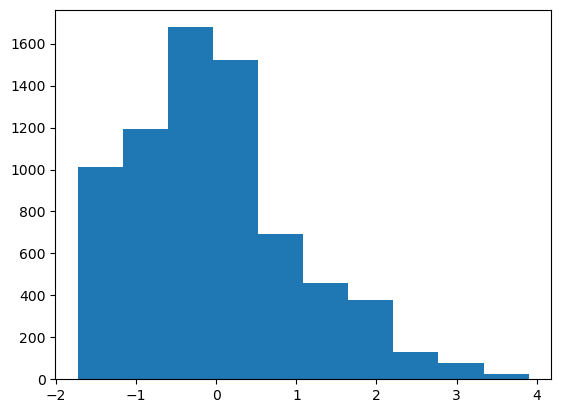

In [8]:
plt.hist(df_train['content']);

## Stratified K-fold

In [9]:
df_train['fold'] = -1
fold = StratifiedKFold(n_splits=config["n_folds"], shuffle=True, random_state=config["seed"])
for n, (train_index, val_index) in enumerate(fold.split(df_train, df_train['prompt_id'])):
    df_train.loc[val_index, 'fold'] = n
df_train['fold'] = df_train['fold'].astype(int)
fold_sizes = df_train.groupby('fold').size()

In [10]:
tokenizer=AutoTokenizer.from_pretrained(config["model"])
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
config['tokenizer']=tokenizer

In [11]:
SEP=tokenizer.sep_token
df_train['full_text_sep']=df_train['prompt_question'] + SEP + df_train['text']
df_train['full_text']    =df_train['prompt_question'] + df_train['text']

In [12]:
max_text=0
for text in df_train['full_text'].values:
    token_len=len(tokenizer(text,add_special_tokens=True)['input_ids'])
    if token_len> max_text:
        max_text=token_len
        
max_text
        

Token indices sequence length is longer than the specified maximum sequence length for this model (659 > 512). Running this sequence through the model will result in indexing errors


877

## Prepare Input 

In [13]:
class Dataset_generator(tf.keras.utils.Sequence):

    def __init__(self, x_set, y1_set,y2_set,config, batch_size):
        self.x, self.y1,self.y2= x_set, y1_set,y2_set
        self.batch_size = batch_size
        self.config=config

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        low = idx * self.batch_size
        # Cap upper bound at array length; the last batch may be smaller
        # if the total number of items is not a multiple of batch size.
        high = min(low + self.batch_size, len(self.x))
        batch_x = self.x[low:high]
        batch_y1 = self.y1[low:high]
        batch_y2 = self.y2[low:high]
        
        x_encoded=config['tokenizer'].batch_encode_plus(
                                batch_x.tolist(),
                                return_tensors='tf',
                                max_length=config['tokenizer'].model_max_length,
                                padding='max_length',
                                truncation=True,
                                return_token_type_ids=False
                            )

        return x_encoded, batch_y1,batch_y2
    
    def _parse_data(self,x):
        for k,v in x.items():
            x[k]=tf.cast(v, tf.float32)
            
        return x
      
train_ds=Dataset_generator(df_train['full_text'].values,df_train['content'].values,df_train['wording'].values,config,config['batch_size'])

In [14]:
class MeanPooling1(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(MeanPooling, self).__init__(**kwargs)

    def call(self, inputs, mask=None):
        if mask is None:
            mask = tf.ones_like(inputs)  # Create a mask of ones if not provided
        mask = tf.cast(mask, tf.float16)
        masked_embeddings = inputs * mask[:, :, tf.newaxis]
        sum_embeddings = tf.reduce_sum(masked_embeddings, axis=1)
        sum_mask = tf.reduce_sum(mask, axis=1)
        sum_mask = tf.clip_by_value(sum_mask, clip_value_min=1e-9, clip_value_max=tf.float32.max)
        mean_embeddings = sum_embeddings / sum_mask[:, tf.newaxis]
        return mean_embeddings

## Declare the Model 

In [15]:
class MeanPooling(tf.keras.layers.Layer):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def call(self, last_hidden_state, attention_mask):
        input_mask_expanded = tf.cast(tf.broadcast_to(tf.expand_dims(attention_mask,-1),last_hidden_state.shape.as_list()),tf.float16)
        sum_embeddings = tf.reduce_sum(last_hidden_state * tf.cast(input_mask_expanded,tf.float16), 1)
        sum_mask = tf.reduce_sum(input_mask_expanded,1)
        sum_mask = tf.clip_by_value(sum_mask, clip_value_min=1e-9,clip_value_max=tf.float32.max)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

    
class CustomModel(tf.keras.Model):

    def __init__(self, config):
        super().__init__()
        
        if config['training']:
            self.embeddings = TFAutoModel.from_pretrained(config['model'])
            self.embeddings.save_pretrained(os.path.join(OUTPUT_DIR,'embedding_model/'))
            
        else:
            self.embedding=TFAutoModel.from_pretrained(os.path.join(OUTPUT_DIR,'embedding_model/'))
        self.global_pool = MeanPooling()
        self.dense1=tf.keras.layers.Dense(96,activation='relu')
        self.dense2=tf.keras.layers.Dense(12,activation='relu')
        self.batch_norm1=tf.keras.layers.BatchNormalization()
        self.batch_norm2=tf.keras.layers.BatchNormalization()
        self.dropout1=tf.keras.layers.Dropout(0.5)
        self.dropout2=tf.keras.layers.Dropout(0.5)
        self.classifier = tf.keras.layers.Dense(2,dtype='float32')

    def call(self, inputs):
        embeddings = self.embeddings(**inputs)
        x = self.global_pool(embeddings[0],inputs['attention_mask'])
        x = self.batch_norm1(x)
        x = self.dense1(x)
        x = self.batch_norm2(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.dropout2(x)
        return self.classifier(x)
    

class MCRMSE(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self,y_true,y_pred):
        y,z=y_true
        content=tf.keras.losses.mean_squared_error(y,y_pred[:,0])
        wording=tf.keras.losses.mean_squared_error(z,y_pred[:,1])
        
        return tf.sqrt((content+wording))/2

class MCRootMeanSquaredError(tf.keras.metrics.Metric):
    def __init__(self, name='mean_squared_error', **kwargs):
        super(MCRootMeanSquaredError, self).__init__(name=name, **kwargs)
        self.sum_squared_error = self.add_weight(name='sum_squared_error', initializer='zeros')
        self.total_samples = self.add_weight(name='total_samples', initializer='zeros')

    def update_state(self, y,z, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred, tf.float32)
        y = tf.cast(y, tf.float32)
        z = tf.cast(z, tf.float32)
        squared_error_1 = tf.reduce_sum(tf.square(y_pred[:,0] - y))
        squared_error_2 = tf.reduce_sum(tf.square(y_pred[:,1] - z))
        
        mcrmse=squared_error_1+squared_error_2
        
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            squared_error *= sample_weight
        self.sum_squared_error.assign_add(mcrmse)
        self.total_samples.assign_add(tf.cast(len(y_pred[:,0]), tf.float32))

    def result(self):
        return (tf.sqrt(self.sum_squared_error / self.total_samples))/2.0

    def reset_states(self):
        self.sum_squared_error.assign(0.0)
        self.total_samples.assign(0.0)

class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self,model,metric,optimizer):
        self.metric=metric.result()
        self.optimizer=optimizer
        self.init_metric=np.inf
        self.model=model
        
    def on_epoch_end(self, epoch, logs={}):  
        keys=list(logs.keys())
        print(f"keys of the logs on epoch end {keys}")
        
    def on_test_batch_end(self,batch,val_metric,logs=None):
        min_val=min(val_metric)
        
        if min_val < self.init_metric:
            
            # Save the model weights 
            print(f"Saving the model since {min_val} is less than {self.init_metric}")
            self.init_metric=min_val
            self.model.save_weights(os.path.join(config['model_path'],'model_weights'))
       
    
    def on_test_batch_begin(self,batch,logs=None):
        self._batch_start_time=datetime.now()
        


## Training Loop

In [16]:

## Declaring 
model=CustomModel(config)
loss_fn=MCRMSE()
train_metric= MCRootMeanSquaredError()
val_metric=MCRootMeanSquaredError()
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3)
optimizer = mixed_precision.LossScaleOptimizer(optimizer)

_callbacks_save=[CustomCallback(model,val_metric,optimizer)]

callbacks_save=tf.keras.callbacks.CallbackList(callbacks=_callbacks_save, model=model)

@tf.function  
def train_step(x, y1, y2):
    with tf.GradientTape() as tape:
        logits=model(x,training=True)
        loss_value=loss_fn(y_true=(y1,y2),y_pred=logits)
        scaled_loss = optimizer.get_scaled_loss(loss_value)
    scaled_gradients=tape.gradient(scaled_loss, model.trainable_weights)
    grads = optimizer.get_unscaled_gradients(scaled_gradients)
    #grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    # Update training metric.
    train_metric.update_state(y1,y2, logits)
    
    return loss_value

@tf.function
def test_step(x, y1, y2):
    val_logits = model(x, training=False)
    val_metric.update_state(y1,y2, val_logits)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [17]:

model.layers[-9].trainable=False


for epoch in range(config['epochs']):
    print(f"Starting epoch --> {epoch}")
    val_rcrmse=[]
    train_rcrmse=[]
    start_time = time.time()
    for fold in range(config['n_folds']):
        fold_start_time=time.time()
        
        print("###################################################################################")
        print(f"Starting fold --> {fold}")
        train=df_train[df_train['fold']!=fold]
        val =df_train[df_train['fold']==fold]
        

        train_dataset = Dataset_generator(train['full_text'].values,train['content'].values,train['wording'].values,config,config["batch_size"])
        val_dataset   = Dataset_generator(val['full_text'].values,val['content'].values,val['wording'].values,config,config["batch_size"])

        for step,(x_batch_train,y1_batch_train,y2_batch_train) in enumerate(train_dataset):
            
            loss_value=train_step(x_batch_train,y1_batch_train,y2_batch_train)
        
            # Log every 100 batches.
            if step % 50 == 0:
                print(
                    "Training loss (for one batch) at step %d: %.4f"
                    % (step, float(loss_value))
                )
                print("Seen so far: %s samples" % ((step + 1) * config['batch_size']))
        
        train_rcrmse.append(train_metric.result())
        train_metric.reset_states()
        
        print("***********************************************************************")
        print(f"Running Validation epoch: {epoch} fold : {fold}")
        #Running validation
        callbacks_save.on_test_batch_begin(0)
        for batch,(x_batch_val, y1_batch_val, y2_batch_val) in enumerate(val_dataset):
        
            test_step(x_batch_val, y1_batch_val, y2_batch_val)
        
        val_rcrmse.append(val_metric.result())
        callbacks_save.on_test_batch_end(batch,val_rcrmse)
        
        val_metric.reset_states()
        print(f"validation score : {val_rcrmse[fold]}")
        print(f"Time taken for epoch:{epoch} fold:{fold}: %.2fs" % (time.time() - fold_start_time))
    
    # Display metrics at the end of epoch.
   
    print(f"Train Metric after epoch:{epoch }: {train_rcrmse}")
    print(f"Val Metric after epoch:{epoch }: {val_rcrmse}")
    print("Time taken: %.2fs" % (time.time() - start_time))
    
    ## Saving the model for the fold
    gc.collect()
    K.clear_session()


Starting epoch --> 0
###################################################################################
Starting fold --> 0
Training loss (for one batch) at step 0: 1.6477
Seen so far: 32 samples
Training loss (for one batch) at step 50: 1.2878
Seen so far: 1632 samples
Training loss (for one batch) at step 100: 0.9225
Seen so far: 3232 samples
Training loss (for one batch) at step 150: 0.7087
Seen so far: 4832 samples
***********************************************************************
Running Validation epoch: 0 fold : 0
Saving the model since 0.7037041783332825 is less than inf
validation score : 0.7037041783332825
Time taken for epoch:0 fold:0: 160.42s
###################################################################################
Starting fold --> 1
Training loss (for one batch) at step 0: 0.9423
Seen so far: 32 samples
Training loss (for one batch) at step 50: 0.6307
Seen so far: 1632 samples
Training loss (for one batch) at step 100: 0.6753
Seen so far: 3232 samples
Trai

### 